In [ ]:
from google.colab import drive
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = datasets.ImageFolder(root="/content/drive/My Drive/image_classification/train/", transform=transform)
test_dataset = datasets.ImageFolder(root="/content/drive/My Drive/image_classification/test/", transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 100)  # First FC layer with 100 nodes
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, len(train_dataset.classes))

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))  # First FC layer
        x = torch.relu(self.fc2(x))  # Second FC layer
        x = self.fc3(x)
        return x

In [ ]:
# Model, loss, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar

# Training loop
epochs = 300
for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}')

100%|██████████| 300/300 [1:36:58<00:00, 19.40s/it]


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 43.86%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to compute accuracy and plot confusion matrix
def evaluate_model(y_true, y_pred, class_names, title="Confusion Matrix"):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100  # Convert to percentage

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{title}\nAccuracy: {accuracy:.2f}%")
    plt.show()

    return accuracy


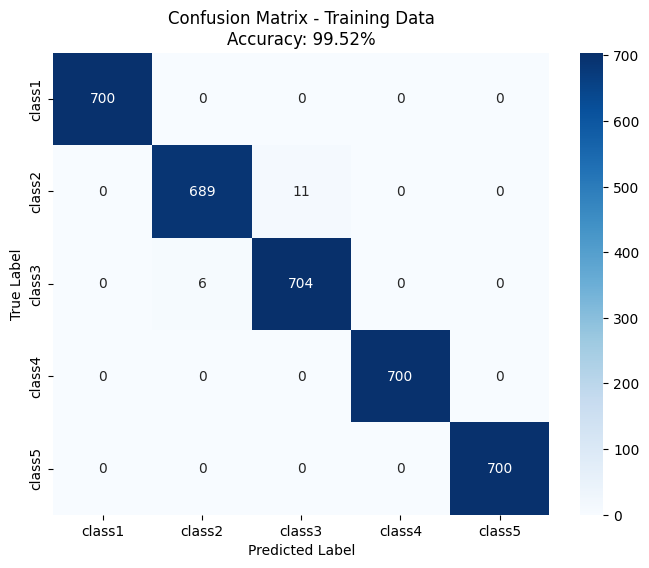

Training Accuracy: 99.52%


In [ ]:
model.eval()
y_true_train = []
y_pred_train = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true_train.extend(labels.cpu().numpy())  # Convert to NumPy and store
        y_pred_train.extend(predicted.cpu().numpy())

# Get class names
class_names = train_dataset.classes  # List of class names

# Evaluate training data
train_accuracy = evaluate_model(y_true_train, y_pred_train, class_names, title="Confusion Matrix - Training Data")
print(f"Training Accuracy: {train_accuracy:.2f}%")


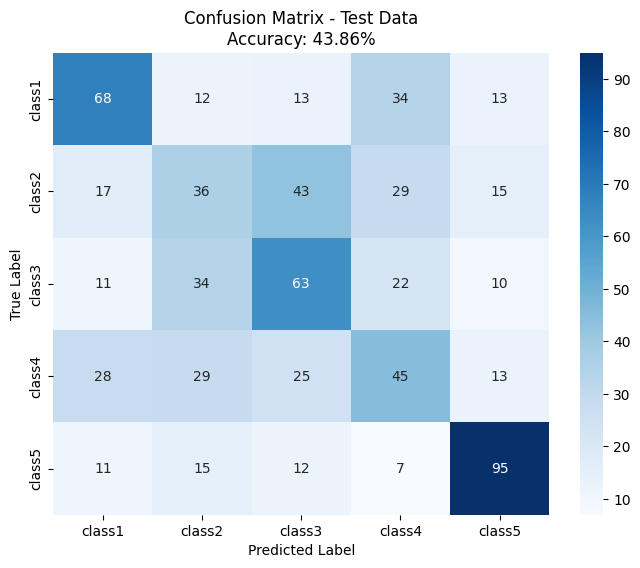

Test Accuracy: 43.86%


In [ ]:
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true_test.extend(labels.cpu().numpy())  # Convert to NumPy and store
        y_pred_test.extend(predicted.cpu().numpy())

# Evaluate test data
test_accuracy = evaluate_model(y_true_test, y_pred_test, class_names, title="Confusion Matrix - Test Data")
print(f"Test Accuracy: {test_accuracy:.2f}%")
